<font size = 5> 0 - Getting Started

In [22]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools
import pickle
plt.rcParams['font.size'] = 20.
plt.rc('axes', labelsize=20) 

In [2]:
N = 300; #Number of binary nodes
M = 10; #Number of Patterns

def generate_pattern(N):
    P = np.ones(N)
    for i in range(N):
        r = np.random.rand()
        if r < 0.5:
            P[i] = -P[i];
    return P

def update_state(S,W):
    return np.sign(W@S)

def flip_percentage(S,c):
    SS = S.copy()
    for i in range(len(S)):
        r = np.random.rand()
        if r < c:
            SS[i] = -SS[i];
    return SS

def hamming_dist(A,B):
    N = len(A)
    return (N-A.dot(B))/(2*N)

#Patterns:
P = []
for i in range(M):
    P.append(generate_pattern(N))

#Weight Matrix

W = np.zeros((N,N))

for i in range(N):
    for j in range(i+1,N):
        for μ in range(M):
            W[i][j] = W[i][j] + P[μ][i]*P[μ][j];
        W[i][j] = W[i][j]/N
        W[j][i] = W[i][j]

        


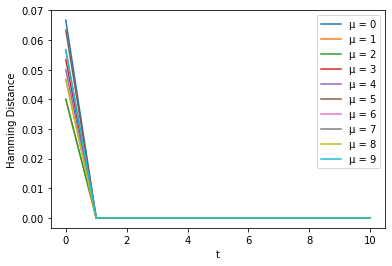

In [3]:
c = 0.05
N_t = 10
for μ in range(M):
    S = P[μ].copy()
    S = flip_percentage(S,c)
    h = [hamming_dist(P[μ],S)]
    for t in range(N_t):
        S = update_state(S,W);
        h.append(hamming_dist(P[μ],S))
    plt.plot(h,label = "μ = %d"%(μ))
    
plt.legend()
plt.xlabel('t')
plt.ylabel("Hamming Distance")
plt.show()

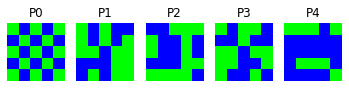

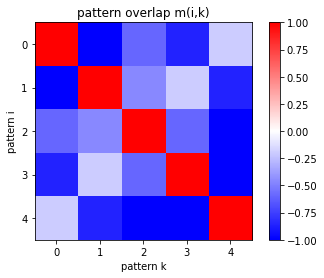

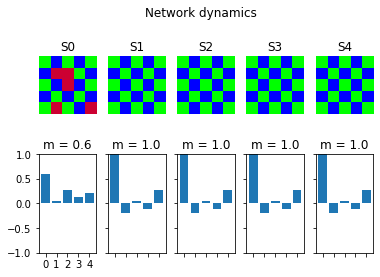

In [4]:

N = 5;

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons = N*N)
# instantiate a pattern factory
factory = pattern_tools.PatternFactory(N, N)
# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]


# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=4, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)
# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
plot_tools.plot_overlap_matrix(overlap_matrix)

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

# create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=5)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=4)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)
# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")



<font size = '5'> 1.1

In [3]:
nr_neurons = 300*1;
nr_patterns = 5;

# create an instance of the class HopfieldNetwork with 300 neurons
hopfield_net = network.HopfieldNetwork(nr_neurons = nr_neurons)
#create 5 patterns
factory = pattern_tools.PatternFactory(nr_neurons,1)
pattern_list = factory.create_random_pattern_list(nr_patterns=nr_patterns, on_probability=0.5)
hopfield_net.store_patterns(pattern_list)

<font size = '5'> 1.2

In [4]:
#Define hamming distance function:
def hamming_distance(A,B):
    N = len(A)
    A = np.reshape(A,N);
    B = np.reshape(B,N)
    return (N-A.dot(B))/(2*N)

#hamming_distance = 1/2*(1-overlap)
def overlap(A,B):
    N = len(A)
    A = np.reshape(A,N);
    B = np.reshape(B,N)
    return (A.dot(B))/(N)

<font size = '5'> 1.3

[0.0, 0.49333333333333335, 0.5366666666666666, 0.5333333333333333, 0.4766666666666667]
[1.0, 0.013333333333333334, -0.07333333333333333, -0.06666666666666667, 0.04666666666666667]


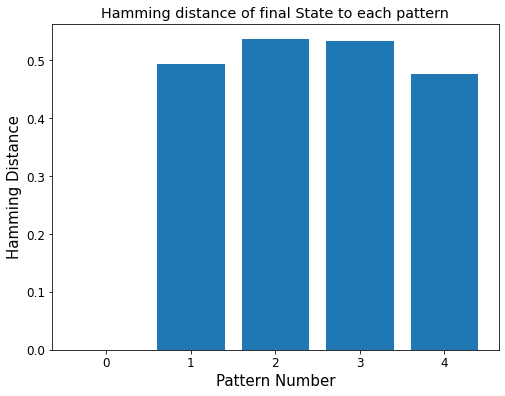

In [5]:
# create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(pattern_list[0], nr_of_flips=int(0.05*nr_neurons))
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve 6 steps.
states = hopfield_net.run_with_monitoring(nr_steps=6)
states_as_patterns = factory.reshape_patterns(states)

#Compute hamming distance of final state to all the patterns:
h_dist = []
overlaps = []
for μ in range(nr_patterns):
    h_dist.append(hamming_distance(states_as_patterns[-1],pattern_list[μ]))
    overlaps.append(overlap(states_as_patterns[-1],pattern_list[μ]))
    
print(h_dist)
print(overlaps)
figure = plt.figure(figsize = (8,6))
plt.bar(np.arange(nr_patterns),height = h_dist)
plt.ylabel('Hamming Distance')
plt.xlabel('Pattern Number')
plt.title('Hamming distance of final State to each pattern')
plt.show()



<font size = '5'> 1.4

In [6]:
def Mean_Error_Pattern_Retrieval(nr_neurons = 300, 
                                 nr_patterns = 5,
                                 max_iter = 1000,
                                 verbose = False,
                                 flip_percentage = 0.05):
    
    hopfield_net.nrOfNeurons = nr_neurons
    factory.pattern_length = nr_neurons
    factory.pattern_width = 1

    pattern_list = factory.create_random_pattern_list(nr_patterns = nr_patterns, on_probability=0.5)
    
    
    hopfield_net.store_patterns(pattern_list)
    
    E = 0;
    accepted_pattern_number = 0
    retrieved_pattern_number = 0
    for μ in range(nr_patterns):
        noisy_init_state = pattern_tools.flip_n(pattern_list[μ], nr_of_flips=int(flip_percentage*nr_neurons))
        hopfield_net.set_state_from_pattern(noisy_init_state)
        
        #Run until convergence
        count = 0;
        conv = False
        while not conv:
            count = count + 1;
            #print(count)
            state_old = hopfield_net.state.copy();
            hopfield_net.run(nr_steps=1);
            state = hopfield_net.state.copy();
            aux = max(abs(state - state_old))
            conv = (aux<1)
            #print(state == state_old)
            #print(conv)
            if count == max_iter:
                if verbose:
                    print("Network state did not converge for pattern ",μ)
                break
        if conv:
            if verbose:
                print('Pattern %i - Converged after %i iterations'%(μ,count)) 
            accepted_pattern_number = accepted_pattern_number + 1;
            
        state = factory.reshape_patterns([hopfield_net.state])
        h = hamming_distance(state[0],pattern_list[μ])
        if h<0.05:
            retrieved_pattern_number += 1;
        if verbose:
            print("Hamming distance = ",h)
        E = E + h
        
    
    print("Convergence  = %d / %d; Retrieved patterns = %d"%(accepted_pattern_number,nr_patterns,retrieved_pattern_number))

    return E/nr_patterns , retrieved_pattern_number/nr_patterns;

In [7]:
Mean_Error_Pattern_Retrieval(nr_patterns = 30,verbose = True)

Pattern 0 - Converged after 2 iterations
Hamming distance =  0.0
Pattern 1 - Converged after 2 iterations
Hamming distance =  0.0033333333333333335
Pattern 2 - Converged after 2 iterations
Hamming distance =  0.0
Pattern 3 - Converged after 3 iterations
Hamming distance =  0.006666666666666667
Pattern 4 - Converged after 2 iterations
Hamming distance =  0.0
Pattern 5 - Converged after 2 iterations
Hamming distance =  0.0
Pattern 6 - Converged after 2 iterations
Hamming distance =  0.0
Pattern 7 - Converged after 2 iterations
Hamming distance =  0.0033333333333333335
Pattern 8 - Converged after 3 iterations
Hamming distance =  0.0
Pattern 9 - Converged after 3 iterations
Hamming distance =  0.0
Pattern 10 - Converged after 2 iterations
Hamming distance =  0.0
Pattern 11 - Converged after 3 iterations
Hamming distance =  0.0033333333333333335
Pattern 12 - Converged after 2 iterations
Hamming distance =  0.0
Pattern 13 - Converged after 2 iterations
Hamming distance =  0.0
Pattern 14 - Co

(0.0005555555555555556, 1.0)

In [7]:
from scipy.interpolate import interp1d
def Evaluate_Mean_Error(M_values,                        
                        nr_neurons = 300,
                        nr_iterations = 8,
                        max_iter = 1000,
                        flip_percentage = 0.05):
    E_values =[];
    E_error  =[];
    Nr_values =[];
    Nr_error  =[];

    for M in M_values:
        print(M)
        E_M = [];
        Nr_M = [];
        for run in range(nr_iterations):
            e,n = Mean_Error_Pattern_Retrieval(nr_neurons = nr_neurons,nr_patterns = M, max_iter = 1000,flip_percentage = flip_percentage)
            E_M.append(e);
            Nr_M.append(n);

        E = np.mean(E_M) 
        var_E = np.std(E_M)
        Nr = np.mean(Nr_M) 
        var_Nr = np.std(Nr_M)

        E_values.append(E)
        E_error.append(var_E)
        Nr_values.append(Nr)
        Nr_error.append(var_Nr)

        print('\n')
         
    capacity = M_max(M_values,E_values)/nr_neurons
    return E_values,E_error,Nr_values,Nr_error,capacity

def M_max(M_values,E_values,threshold = 0.05):
    C = 0;
    E_interp = interp1d(M_values, E_values, kind='cubic')
    m = np.arange(M_values[0],M_values[-1])
    k = 0
    while (E_interp(m[k])-threshold)*(E_interp(m[k+1])-threshold) > 0 and k<(len(m)-2):
        k = k+1
    
    if k<(len(m)-2):
        m_max = m[k]   
    else:
        print('Capacity not Found')
        m_max = m[-1]
    return m_max
    

In [25]:
M_values = [5,10,20,40,60,80,100]
E_values,E_error,Nr_values,Nr_error,capacity = Evaluate_Mean_Error(M_values,nr_iterations = 1)
DATA = [M_values,E_values,E_error,Nr_values,Nr_error,capacity]
with open('Q1.4.pickle','wb') as f:
    pickle.dump(DATA,f)

5
Convergence  = 5 / 5; Retrieved patterns = 5


10
Convergence  = 10 / 10; Retrieved patterns = 10


20
Convergence  = 20 / 20; Retrieved patterns = 20


40
Convergence  = 38 / 40; Retrieved patterns = 36


60
Convergence  = 34 / 60; Retrieved patterns = 10


80
Convergence  = 42 / 80; Retrieved patterns = 1


100
Convergence  = 51 / 100; Retrieved patterns = 0




In [23]:
with open('Q1.4.pickle','rb') as f:
    DATA = pickle.load(f)
M_values = DATA[0]
E_values = DATA[1]
E_error = DATA[2]
Nr_values = DATA[3]
Nr_error = DATA[4]
capacity = DATA[5]

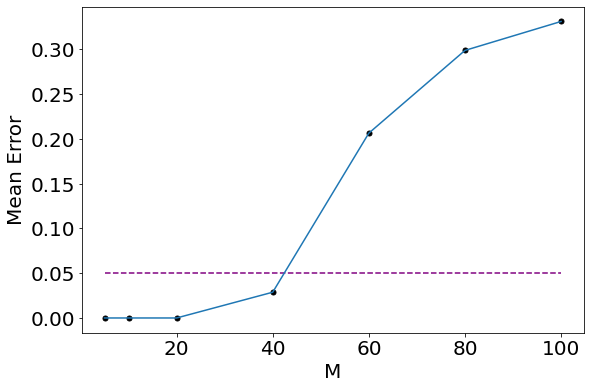

In [24]:
fig = plt.figure(figsize = (9,6))

plt.errorbar(M_values,E_values,yerr = E_error,fmt = '-')
plt.plot(M_values,E_values,'.',color = 'k',markersize = 10.)
plt.plot(M_values,0.05*np.ones(len(M_values)),'--',color = 'purple')
plt.xlabel('M')
plt.ylabel('Mean Error')
plt.show()

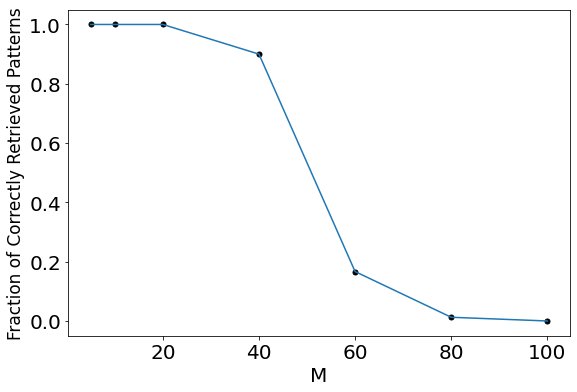

In [28]:
fig = plt.figure(figsize = (9,6))

plt.errorbar(M_values,Nr_values,yerr = Nr_error,fmt = '-')
plt.plot(M_values,Nr_values,'.',color = 'k',markersize = 10.)
plt.xlabel('M')
plt.ylabel('Fraction of Correctly Retrieved Patterns',fontsize = 17)
plt.show()

<font size = '5'> 1.5

In [14]:
M_values = [5,10,20,40,60,80,100]
E_values,E_error,Nr_values,Nr_error,capacity = Evaluate_Mean_Error(M_values, 
                                                                   max_iter = 100)
DATA = [M_values,E_values,E_error,Nr_values,Nr_error,capacity]
with open('Q1.5.pickle','wb') as f:
    pickle.dump(DATA,f)

5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5


10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10


20
Convergence  = 20 / 20; Retrieved patterns = 20
Convergence  = 20 / 20; Retrieved patterns = 20
Convergence  = 20 / 20; Retrieved patterns = 20
Convergence  = 20 / 20; Retrieved patterns = 20
Convergence  = 20 / 20; Retrieved patterns = 20
Conv

In [29]:
with open('Q1.5.pickle','rb') as f:
    DATA = pickle.load(f)
M_values = DATA[0]
E_values = DATA[1]
E_error = DATA[2]
Nr_values = DATA[3]
Nr_error = DATA[4]
capacity = DATA[5]

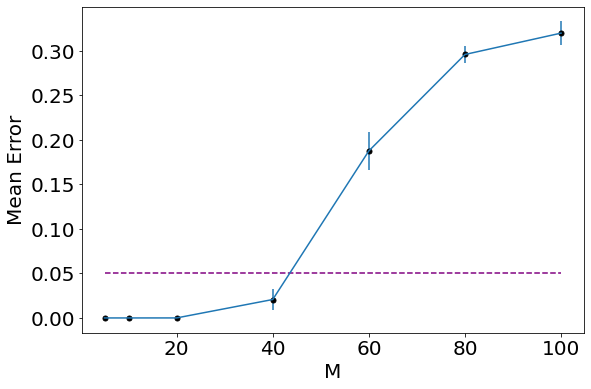

In [30]:
fig = plt.figure(figsize = (9,6))

plt.errorbar(M_values,E_values,yerr = E_error,fmt = '-')
plt.plot(M_values,E_values,'.',color = 'k',markersize = 10.)
plt.plot(M_values,0.05*np.ones(len(M_values)),'--',color = 'purple')
plt.xlabel('M')
plt.ylabel('Mean Error')
plt.show()

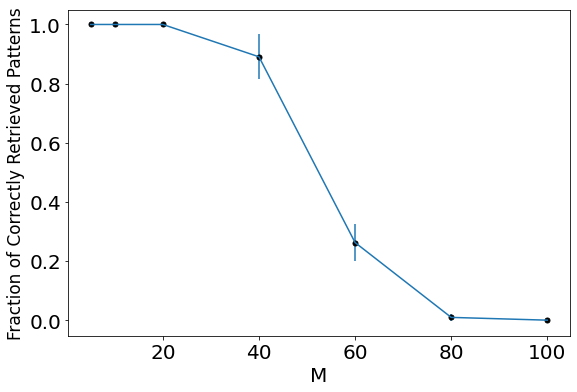

In [31]:
fig = plt.figure(figsize = (9,6))

plt.errorbar(M_values,Nr_values,yerr = Nr_error,fmt = '-')
plt.plot(M_values,Nr_values,'.',color = 'k',markersize = 10.)
plt.xlabel('M')
plt.ylabel('Fraction of Correctly Retrieved Patterns',fontsize = 17)
plt.show()

<font size = '5'> 1.6

In [15]:
M_values = np.arange(5,105,5)
E_values,E_error,Nr_values,Nr_error,capacity = Evaluate_Mean_Error(M_values,
                                                                   max_iter = 100)
DATA = [M_values,E_values,E_error,Nr_values,Nr_error,capacity]
with open('Q1.6.pickle','wb') as f:
    pickle.dump(DATA,f)

5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5


10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10


15


KeyboardInterrupt: 

In [8]:
with open('Q1.6.pickle','rb') as f:
    DATA = pickle.load(f)
    
M_values = DATA[0]
E_values = DATA[1]
E_error = DATA[2]
Nr_values = DATA[3]
Nr_error = DATA[4]
capacity = DATA[5]

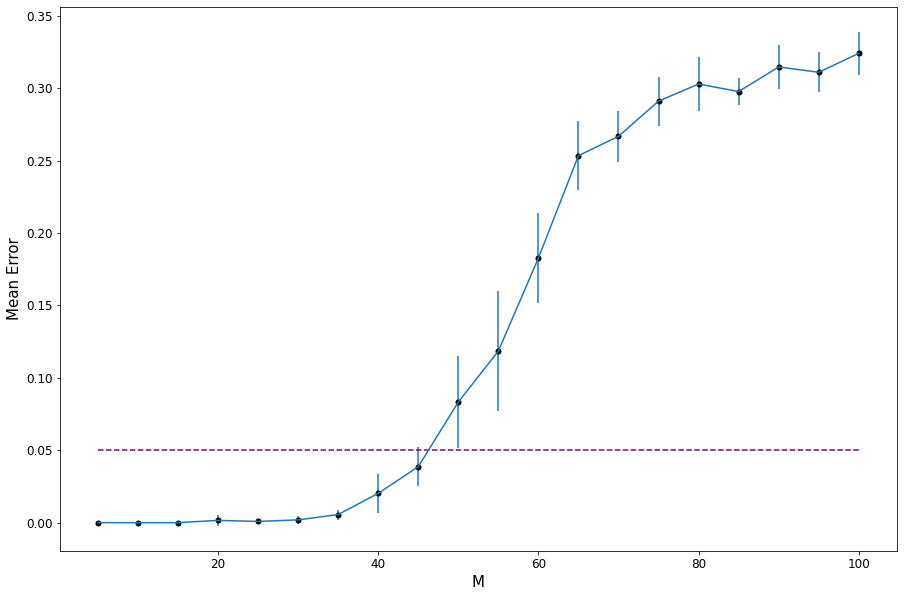

In [9]:
fig = plt.figure(figsize = (15,10))

plt.errorbar(M_values,E_values,yerr = E_error,fmt = '-')
plt.plot(M_values,E_values,'.',color = 'k',markersize = 10.)
plt.plot(M_values,0.05*np.ones(len(M_values)),'--',color = 'purple')
plt.xlabel('M')
plt.ylabel('Mean Error')
plt.show()

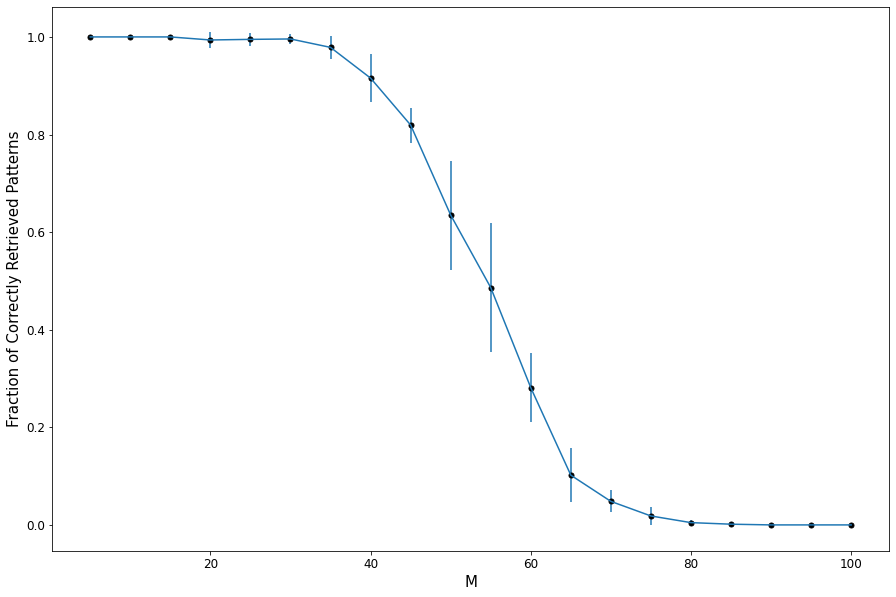

In [10]:
fig = plt.figure(figsize = (15,10))

plt.errorbar(M_values,Nr_values,yerr = Nr_error,fmt = '-')
plt.plot(M_values,Nr_values,'.',color = 'k',markersize = 10.)
plt.xlabel('M')
plt.ylabel('Fraction of Correctly Retrieved Patterns')
plt.show()

In [11]:
#What is the capacity of the network:
print("Capactiy:",capacity)

Capactiy: 0.15333333333333332


<font size = '5'> 1.7

In [19]:
#now for many networks:
import time

Network_Neuron_Numbers = [50,100,250,500,750,1000]
M_values = [5,10,20,30,40,50,60,70,80,90,100,120,140,160]
EE_values =[]
EE_errors =[]
NNr_values=[]
NNr_errors=[]
Capacities=[]

start = time.time();

for nr_neurons in Network_Neuron_Numbers:
    print("Number of Neurons: ",nr_neurons)
    E_values,E_error,Nr_values,Nr_error,capacity = Evaluate_Mean_Error(M_values,
                                                                       nr_neurons = nr_neurons,
                                                                       nr_iterations = 5,
                                                                       max_iter = 100)   
    
    EE_values.append(E_values)
    EE_errors.append(E_error)
    NNr_values.append(Nr_values)
    NNr_errors.append(Nr_error)
    Capacities.append(capacity)
    
    end = time.time()
    duration = end-start;
    print("%d Neurons - Duration: %.2f s"%(nr_neurons,duration)) 
    start = end
    
DATA = [Network_Neuron_Numbers,M_values,EE_values,EE_errors,NNr_values,NNr_errors,Capacities]

with open('nr_neurons.pickle', 'wb') as f:
    pickle.dump(DATA, f)   

Number of Neurons:  50
5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5


10
Convergence  = 10 / 10; Retrieved patterns = 9
Convergence  = 9 / 10; Retrieved patterns = 6
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 9
Convergence  = 9 / 10; Retrieved patterns = 9


20
Convergence  = 16 / 20; Retrieved patterns = 5
Convergence  = 17 / 20; Retrieved patterns = 0
Convergence  = 18 / 20; Retrieved patterns = 0
Convergence  = 15 / 20; Retrieved patterns = 0
Convergence  = 17 / 20; Retrieved patterns = 0


30
Convergence  = 17 / 30; Retrieved patterns = 0
Convergence  = 23 / 30; Retrieved patterns = 0
Convergence  = 21 / 30; Retrieved patterns = 0
Convergence  = 19 / 30; Retrieved patterns = 0
Convergence  = 23 / 30; Retrieved patterns = 0


40
Convergence  = 25 / 40; Re

Convergence  = 41 / 50; Retrieved patterns = 16
Convergence  = 25 / 50; Retrieved patterns = 16
Convergence  = 32 / 50; Retrieved patterns = 11


60
Convergence  = 42 / 60; Retrieved patterns = 9
Convergence  = 32 / 60; Retrieved patterns = 5
Convergence  = 35 / 60; Retrieved patterns = 2
Convergence  = 39 / 60; Retrieved patterns = 3
Convergence  = 38 / 60; Retrieved patterns = 5


70
Convergence  = 44 / 70; Retrieved patterns = 0
Convergence  = 38 / 70; Retrieved patterns = 0
Convergence  = 45 / 70; Retrieved patterns = 1
Convergence  = 47 / 70; Retrieved patterns = 1
Convergence  = 44 / 70; Retrieved patterns = 2


80
Convergence  = 46 / 80; Retrieved patterns = 0
Convergence  = 39 / 80; Retrieved patterns = 0
Convergence  = 37 / 80; Retrieved patterns = 0
Convergence  = 47 / 80; Retrieved patterns = 0
Convergence  = 42 / 80; Retrieved patterns = 0


90
Convergence  = 59 / 90; Retrieved patterns = 0
Convergence  = 39 / 90; Retrieved patterns = 0
Convergence  = 48 / 90; Retrieved pat

Convergence  = 91 / 100; Retrieved patterns = 97
Convergence  = 79 / 100; Retrieved patterns = 89


120
Convergence  = 76 / 120; Retrieved patterns = 68
Convergence  = 80 / 120; Retrieved patterns = 75
Convergence  = 82 / 120; Retrieved patterns = 68
Convergence  = 68 / 120; Retrieved patterns = 76
Convergence  = 78 / 120; Retrieved patterns = 82


140
Convergence  = 62 / 140; Retrieved patterns = 18
Convergence  = 73 / 140; Retrieved patterns = 34
Convergence  = 68 / 140; Retrieved patterns = 20
Convergence  = 72 / 140; Retrieved patterns = 22
Convergence  = 65 / 140; Retrieved patterns = 26


160
Convergence  = 67 / 160; Retrieved patterns = 4
Convergence  = 69 / 160; Retrieved patterns = 2
Convergence  = 71 / 160; Retrieved patterns = 1
Convergence  = 75 / 160; Retrieved patterns = 2
Convergence  = 64 / 160; Retrieved patterns = 0


750 Neurons - Duration: 2764.09 s
Number of Neurons:  1000
5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
C

In [32]:
f = open('nr_neurons.pickle','rb') 
DATA = pickle.load(f)
f.close()
_Network_Neuron_Numbers = DATA[0];
_M_values = DATA[1];
_EE_values = DATA[2];
_EE_errors = DATA[3];
_NNr_values = DATA[4];
_NNr_errors = DATA[5];
_Capacities = DATA[6];
print(len(_EE_values))

6


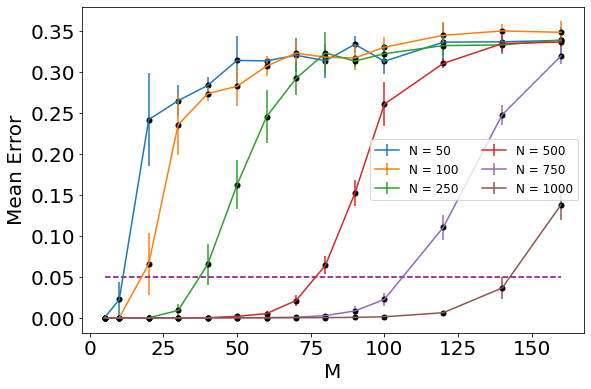

In [36]:
fig = plt.figure(figsize = (9,6))
for i in range(len(_Network_Neuron_Numbers)):
    plt.errorbar(_M_values,_EE_values[i],yerr = _EE_errors[i],fmt = '-',label = 'N = %d'%(_Network_Neuron_Numbers[i]))
    plt.plot(_M_values,_EE_values[i],'.',color = 'k',markersize = 10.)


plt.plot(_M_values,0.05*np.ones(len(_M_values)),'--',color = 'purple')
plt.xlabel('M')
plt.ylabel('Mean Error')
plt.legend(ncol=2,fontsize=12)
plt.show()

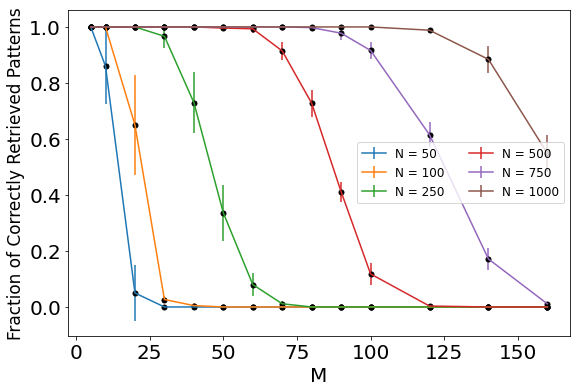

In [38]:
fig = plt.figure(figsize = (9,6))
for i in range(len(_Network_Neuron_Numbers)):
    plt.errorbar(_M_values,_NNr_values[i],yerr = _NNr_errors[i],fmt = '-',label = 'N = %d'%(_Network_Neuron_Numbers[i]))
    plt.plot(_M_values,_NNr_values[i],'.',color = 'k',markersize = 10.)

plt.xlabel('M')
plt.ylabel('Fraction of Correctly Retrieved Patterns',fontsize = 17)
plt.legend(ncol=2,fontsize = 12)
plt.show()

In [34]:
#now for many networks without flipping:
import time

Network_Neuron_Numbers = [50,100,250,500,750,1000]
M_values = [5,10,20,30,40,50,60,70,80,90,100,120,140,160]
EE_values =[]
EE_errors =[]
NNr_values=[]
NNr_errors=[]
Capacities=[]

start = time.time();

for nr_neurons in Network_Neuron_Numbers:
    print("Number of Neurons: ",nr_neurons)
    E_values,E_error,Nr_values,Nr_error,capacity = Evaluate_Mean_Error(M_values,
                                                                       nr_neurons = nr_neurons,
                                                                       nr_iterations = 5,
                                                                       flip_percentage = 0,
                                                                       max_iter = 100)   
    
    EE_values.append(E_values)
    EE_errors.append(E_error)
    NNr_values.append(Nr_values)
    NNr_errors.append(Nr_error)
    Capacities.append(capacity)
    
    end = time.time()
    duration = end-start;
    print("%d Neurons - Duration: %.2f s"%(nr_neurons,duration)) 
    start = end
    
DATA = [Network_Neuron_Numbers,M_values,EE_values,EE_errors,NNr_values,NNr_errors,Capacities]

with open('nr_neurons_0_flip.pickle', 'wb') as f:
    pickle.dump(DATA, f)   

Number of Neurons:  50
5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5


10
Convergence  = 10 / 10; Retrieved patterns = 8
Convergence  = 10 / 10; Retrieved patterns = 9
Convergence  = 10 / 10; Retrieved patterns = 7
Convergence  = 10 / 10; Retrieved patterns = 9
Convergence  = 10 / 10; Retrieved patterns = 10


20
Convergence  = 16 / 20; Retrieved patterns = 3
Convergence  = 16 / 20; Retrieved patterns = 0
Convergence  = 16 / 20; Retrieved patterns = 1
Convergence  = 14 / 20; Retrieved patterns = 0
Convergence  = 19 / 20; Retrieved patterns = 3


30
Convergence  = 24 / 30; Retrieved patterns = 0
Convergence  = 26 / 30; Retrieved patterns = 0
Convergence  = 20 / 30; Retrieved patterns = 1
Convergence  = 18 / 30; Retrieved patterns = 0
Convergence  = 24 / 30; Retrieved patterns = 0


40
Convergence  = 24 / 40; 

Convergence  = 38 / 50; Retrieved patterns = 14
Convergence  = 37 / 50; Retrieved patterns = 24
Convergence  = 41 / 50; Retrieved patterns = 20


60
Convergence  = 38 / 60; Retrieved patterns = 8
Convergence  = 36 / 60; Retrieved patterns = 5
Convergence  = 33 / 60; Retrieved patterns = 4
Convergence  = 39 / 60; Retrieved patterns = 8
Convergence  = 39 / 60; Retrieved patterns = 7


70
Convergence  = 42 / 70; Retrieved patterns = 2
Convergence  = 38 / 70; Retrieved patterns = 2
Convergence  = 41 / 70; Retrieved patterns = 0
Convergence  = 33 / 70; Retrieved patterns = 0
Convergence  = 47 / 70; Retrieved patterns = 1


80
Convergence  = 43 / 80; Retrieved patterns = 1
Convergence  = 41 / 80; Retrieved patterns = 0
Convergence  = 44 / 80; Retrieved patterns = 0
Convergence  = 47 / 80; Retrieved patterns = 0
Convergence  = 39 / 80; Retrieved patterns = 0


90
Convergence  = 50 / 90; Retrieved patterns = 0
Convergence  = 45 / 90; Retrieved patterns = 0
Convergence  = 49 / 90; Retrieved pat

Convergence  = 89 / 100; Retrieved patterns = 95
Convergence  = 97 / 100; Retrieved patterns = 94


120
Convergence  = 94 / 120; Retrieved patterns = 77
Convergence  = 82 / 120; Retrieved patterns = 67
Convergence  = 90 / 120; Retrieved patterns = 87
Convergence  = 97 / 120; Retrieved patterns = 74
Convergence  = 96 / 120; Retrieved patterns = 77


140
Convergence  = 68 / 140; Retrieved patterns = 19
Convergence  = 70 / 140; Retrieved patterns = 29
Convergence  = 70 / 140; Retrieved patterns = 31
Convergence  = 66 / 140; Retrieved patterns = 30
Convergence  = 71 / 140; Retrieved patterns = 24


160
Convergence  = 63 / 160; Retrieved patterns = 7
Convergence  = 53 / 160; Retrieved patterns = 5
Convergence  = 63 / 160; Retrieved patterns = 1
Convergence  = 65 / 160; Retrieved patterns = 0
Convergence  = 58 / 160; Retrieved patterns = 7


750 Neurons - Duration: 2208.41 s
Number of Neurons:  1000
5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
C

In [39]:
f = open('nr_neurons_0_flip.pickle','rb') 
DATA = pickle.load(f)
f.close()
_Network_Neuron_Numbers_0 = DATA[0];
_M_values_0 = DATA[1];
_EE_values_0 = DATA[2];
_EE_errors_0 = DATA[3];
_NNr_values_0 = DATA[4];
_NNr_errors_0 = DATA[5];
_Capacities_0 = DATA[6];

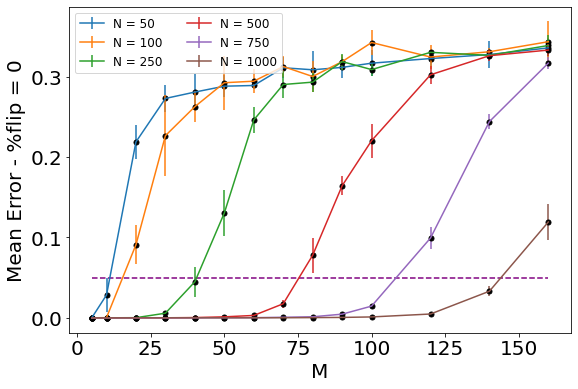

In [40]:
fig = plt.figure(figsize = (9,6))
for i in range(len(_Network_Neuron_Numbers_0)):
    plt.errorbar(_M_values_0,_EE_values_0[i],yerr = _EE_errors_0[i],fmt = '-',label = 'N = %d'%(_Network_Neuron_Numbers_0[i]))
    plt.plot(_M_values_0,_EE_values_0[i],'.',color = 'k',markersize = 10.)


plt.plot(_M_values,0.05*np.ones(len(_M_values)),'--',color = 'purple')
plt.xlabel('M')
plt.ylabel('Mean Error - %flip = 0')
plt.legend(ncol=2,fontsize=12)
plt.show()

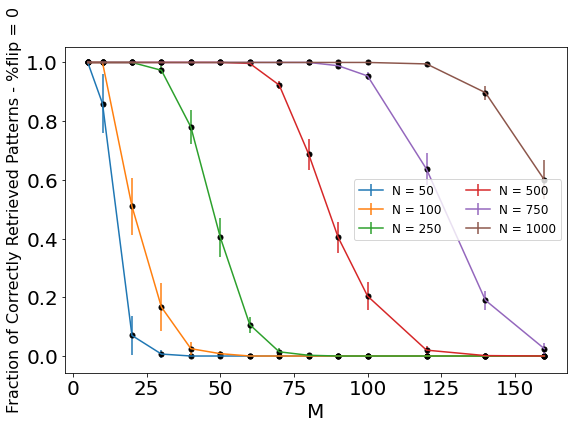

In [41]:
fig = plt.figure(figsize = (9,6))
for i in range(len(_Network_Neuron_Numbers_0)):
    plt.errorbar(_M_values_0,_NNr_values_0[i],yerr = _NNr_errors_0[i],fmt = '-',label = 'N = %d'%(_Network_Neuron_Numbers_0[i]))
    plt.plot(_M_values_0,_NNr_values_0[i],'.',color = 'k',markersize = 10.)

plt.xlabel('M')
plt.ylabel('Fraction of Correctly Retrieved Patterns - %flip = 0',fontsize = 16)
plt.legend(ncol=2,fontsize=12)
plt.show()

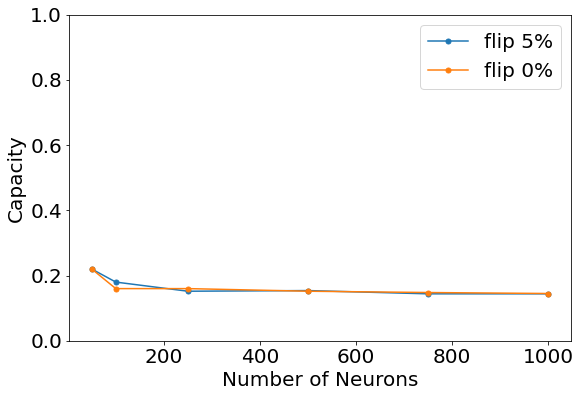

In [43]:
fig = plt.figure(figsize = (9,6))
plt.ylim([0,1.])
r = 1/np.arange(50,1000,1);
plt.plot(_Network_Neuron_Numbers,_Capacities,'.-',markersize = 10,label = "flip 5%")
plt.plot(_Network_Neuron_Numbers_0,_Capacities_0,'.-',markersize = 10,label = "flip 0%")
#plt.plot(np.arange(50,1000,1),r+0.15)
#plt.plot(n_range,theo_cps)
plt.xlabel('Number of Neurons')
plt.ylabel('Capacity')
plt.legend(fontsize= 20)

In [40]:
print(_Capacities_0)


[0.22, 0.16, 0.16, 0.152, 0.148, 0.145]
